# Cross-Assay Integrative Analyses

In [53]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn

%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [46]:
varchamp_pillar_df = pl.read_csv("../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
                                 separator="\t", infer_schema_length=1000000)
print("VarChAMP dataset shape:", varchamp_pillar_df.shape)

VarChAMP dataset shape: (130649, 582)


In [47]:
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("gene_variant")

symbol,ensembl_gene_id,orf_id_wt,mutation_id_old,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,gene_variant,chr_num,nuc_loc,ref_allele,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i64,f64,str,…,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str
"""MSH2""","""ENSG00000095002""",7918,202671,"""CCSBVarC003011""","""ALE00003011""","""NC_000002.12:47466718:G:C""","""1571G>C""","""Arg524Pro""","""CEGS2""","""CegsMutGDEh1047""","""C02""","""GDEhDisVCh_40060""","""E10""","""2""","""CegsMutGDDh1047""","""C02""","""NULL""","""NULL""","""VUSMutpDEST2_07""","""A04""","""NULL""","""NULL""",1,"""1""",1,"""1""",0,"""NULL""",1,"""1""",0,"""NULL""","""MSH2_Arg524Pro""",2,4.7466718e7,"""G""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Arg524Pro""","""Arg524Pro""",true,"""2:47466718:G:C"""
"""TP53""","""ENSG00000141510""",3774,214908,"""CCSBVarC004877""","""ALE00004877""","""NC_000017.11:7673751:C:T""","""869G>A""","""Arg290His""","""CEGS2""","""CegsMutGDEh1021""","""A05""","""GDEhDisVCh_40053""","""D07""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,"""1""",0,"""NULL""",0,"""NULL""",0,"""NULL""",0,"""NULL""","""TP53_Arg290His""",17,7.673751e6,"""C""",…,null,null,0.917877,1.0,0.144691,0.439699,0.054552,0.003186,0.1,0.000354,"""Benign""",null,null,null,127825.0,"""CA000468""","""Li-Fraumeni syndrome""","""MONDO:0018875""","""Autosomal dominant inheritance""","""Benign""","""BS2,BS3,BP4""","""PM2,PVS1,PS1,PS2,PS3,PS4,PM1,P…","""The NM_000546.6: c.869G>A vari…",null,"""TP53 VCEP""","""https://cspec.clinicalgenome.o…","""8/5/24""","""8/5/24""",false,"""https://erepo.genome.network/e…","""de5ede53-7b6d-40ad-8a0e-0b3aa4…","""VUS""","""BS2""","""TP53_Arg290His""","""Arg290His""",true,"""17:7673751:G:A"""
"""OTC""","""ENSG00000036473""",71569,205886,"""CCSBVarC005240""","""ALE00005240""","""NC_000023.11:38401304:T:C""","""416T>C""","""Leu139Ser""","""CEGS2""","""CegsMutGDEh1016""","""F07""","""GDEhDisVCh_40048""","""B03""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",""

In [40]:
pillar_clinvar_df = pl.read_csv(
    "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1053945, 102)
Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Gly""","""Ala148Gly""",true
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thyge

### 1.2 Imaging Data

In [27]:
img_metric_df = pl.DataFrame()
img_metric_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_metric_df = img_metric_df.with_columns(
    pl.col("gene_allele").alias("gene_variant")
)
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])
img_metric_df

VarChAMP Imaging assay unique variants: 476


Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,gene_variant,ensembl_gene_id,clinvar_clnsig_clean,gnomad_af,StarStatus
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,str,str,str,str,i64
"""RAF1""","""RAF1_Phe22Leu""",3.724426,0.067943,-1.462482,1.0,"""2025_01_Batch_13-14""",0.626109,0.695168,0.678365,0.656965,0.594665,0.639809,0.709154,0.641875,0.672886,0.592105,0.632959,0.702161,0.66012,0.664925,0.593385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""RAF1_Phe22Leu""",null,null,null,null
"""CCM2""","""CCM2_Ile432Thr""",4.3807e7,0.067872,-2.743227,1.0,"""2025_01_Batch_13-14""",0.878802,0.964531,0.991095,0.958595,0.988425,0.736454,0.955414,0.988105,0.941591,0.978901,0.807628,0.959972,0.9896,0.950093,0.983663,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,true,null,null,null,null,"""CCM2_Ile432Thr""",null,null,null,null
"""BRCA1""","""BRCA1_Ser611Arg""",3.030701,0.022173,-4.562711,0.01245,"""2025_01_Batch_13-14""",0.955394,0.950793,0.908419,0.94949,0.883888,0.980993,0.939625,0.921506,0.978985,0.889371,0.968193,0.945209,0.914962,0.964238,0.88663,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""BRCA1_Ser611Arg""",null,null,null,null
"""CCM2""","""CCM2_Ser84Asn""",3.816347,0.120511,-7.167999,0.000433,"""2025_01_Batch_13-14""",0.833828,0.788979,0.866667,0.809481,0.768644,0.795332,0.905584,0.955638,0.90568,0.711512,0.81458,0.847282,0.911153,0.85758,0.740078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""CCM2_Ser84Asn""",null,null,null,null
"""CCM2""","""CCM2_Gly407Asp""",2.3705e7,0.026605,-4.642157,0.007201,"""2025_01_Batch_13-14""",0.885675,0.926891,0.958821,0.905666,0.783829,0.829151,0.882549,0.867192,0.843313,0.758269,0.857413,0.90472,0.913006,0.87449,0.771049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""CCM2_Gly407Asp""",null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SHOC2""","""SHOC2_Leu174Phe""",3.41565,0.011201,1.217907,0.262714,"""2025_01_Batch_13-14""",0.929536,0.952093,0.811576,0.927802,0.831083,0.938101,0.891102,0.871414,0.896341,0.939889,0.933819,0.921598,0.841495,0.912071,0.885486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,null,null,null,null,"""SHOC2_Leu174Phe""",null,null,null,null
"""F9""","""F9_Cys268Trp""",null,null,-3.676126,0.0079,"""2025_01_Batch_13-14""",null,0.814609,0.952565,0.899282,null,0.91365,0.892599,0.977609,0.932706,0.872528,null,0.853604,0.965087,0.915994,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,52861,204367,"""F9""","""Cys268Trp""","""F9_Cys268Trp""","""ENSG00000101981""","""1_Pathogenic""",null,null
"""F9""","""F9_Cys124Tyr""",null,null,-7.778249,0.000109,"""2025_01_Batch_13-14""",null,0.939144,0.977718,0.977245,null,0.988603,0.945672,0.970513,0.949987,0.962906,null,0.942408,0.974115,0.963616,null,null,0.0,1.0,0.0,null,null,0.0,0.0,0.0,null,true,null,null,null,null,"""F9_Cys124Tyr""",null,null,null,null


### 1.3 DUAL-IPA and PPI alleles

VarChAMP DUAL-IPA assay unique variants: 919
VarChAMP DUAL-IPA assay unique variants: 586
VarChAMP DUAL-IPA and PPI assay unique variants: 1186


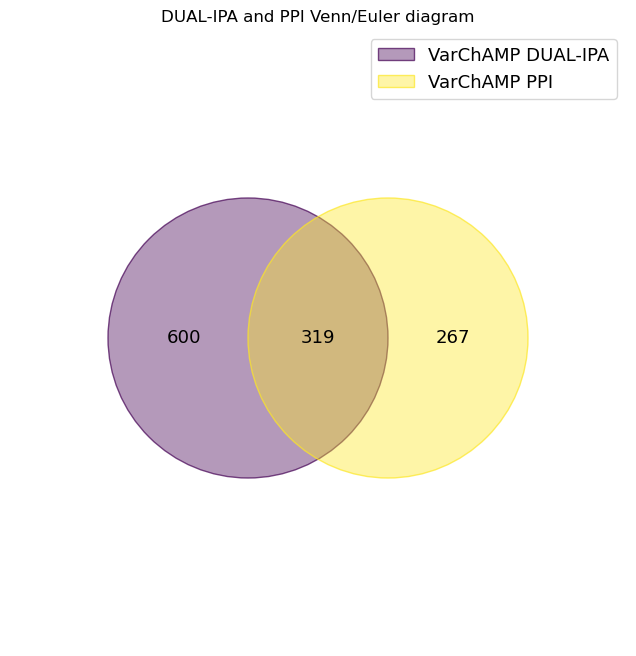

In [54]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv", infer_schema_length=1000000)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["gene_variant"]).shape[0])
ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
print("VarChAMP DUAL-IPA assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

# ppi_df = pl.read_csv("../1_inputs/ppi/edgotyping_final_combined_scores.csv").with_columns(
#     pl.lit(True).alias("VarChAMP_PPI")
# )
# ppi_df = ppi_df.join(
#     ppi_sum_df,
#     on="gene_variant"
# )

dual_ppi_df = dual_ipa_df.join(
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)
print("VarChAMP DUAL-IPA and PPI assay unique variants:", dual_ppi_df.unique(subset=["gene_variant"]).shape[0])

# Create the diagrams with your data
dual_ppi_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

venn(dual_ppi_set)
plt.title("DUAL-IPA and PPI Venn/Euler diagram")
plt.show()

<Axes: xlabel='zscore_log2', ylabel='perturbed_percentage'>

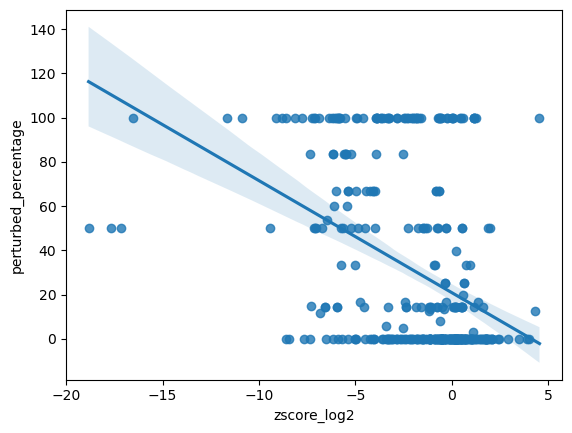

In [57]:
sns.regplot(data=dual_ppi_df.to_pandas(),
            x="zscore_log2",
            y="perturbed_percentage")

In [ ]:
print("VarChAMP PPI assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

img_dual_ppi_df = img_metric_df.join( ## .unique(subset=["gene_variant"])
    dual_ipa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
).join( ## .unique(subset=["gene_variant"])
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)

In [36]:
img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
img_dual_ppi_df

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,RefSeq_mRNA,StarStatus_dualipa,clinvar_clnsig_clean_dualipa,chr,chr_pos_38,ref_right,alt_right,gnomad_af_dualipa,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,ppi_assayed,orf_id_ppi,mut_id_ppi,symbol_ppi,aa_change_ppi,ensembl_gene_id_ppi,clinvar_clnsig_clean_ppi,gnomad_af_ppi,StarStatus_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,i64,i64,i64,i64,f64,f64,f64,bool,i64,i64,str,str,str,str,str,i64
"""KCNJ2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""A""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000223548""","""-""","""-""","""821A>T ""","""Asp274Val""","""NM_000891.3""",1.0,"""4_VUS""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""PKP2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""T""","""C""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000236225|SCV000761608|SCV0…","""-""","""-""","""1415A>G ""","""Lys472Arg""","""NM_001005242.3""",2.0,"""4_VUS""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KCNJ2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV001446813|SCV004571381""","""-""","""-""","""899G>A ""","""Gly300Asp""","""NM_000891.3""",2.0,"""1_Pathogenic""",null,null,null,null,null,2,0,0,2,0.0,0.0,100.0,true,100016069,2641,"""KCNJ2""","""Gly300Asp""","""ENSG00000123700""","""1_Pathogenic""",null,2
"""HBD""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""G""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000036502""","""-""","""-""","""174C>A ""","""Asn58Lys""","""NM_000519.4""",null,"""5_Others""",null,null,null,null,null,1,0,0,1,0.0,0.0,100.0,true,13796,218146,"""HBD""","""Asn58Lys""","""ENSG00000223609""","""5_Others""",null,null
"""SMAD3""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""C""","""T""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000317389""","""-""","""-""","""376C>T ""","""His126Tyr""","""NM_005902.4""",1.0,"""4_VUS""",null,null,null,n

In [43]:
# g = sns.catplot(data=pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]).unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
#                 x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

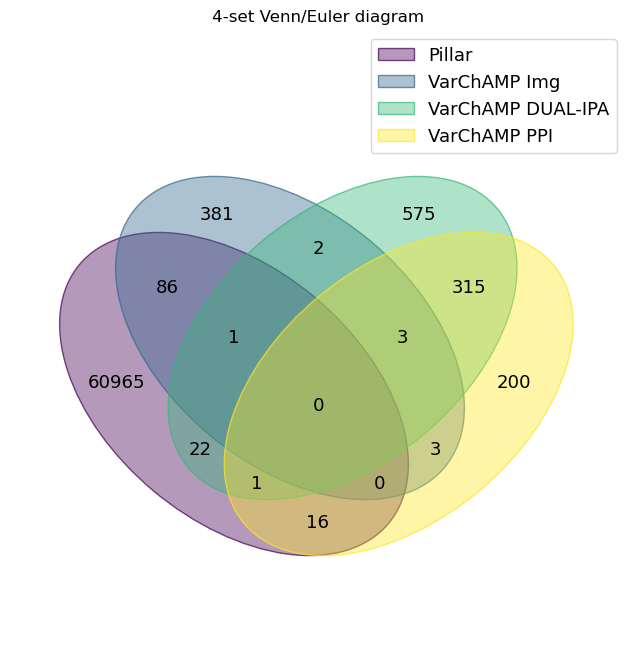

In [48]:
from venn import venn

# Create the diagrams with your data
sets_data = {
    'Pillar': set(pillar_clinvar_single_aa_df["gene_variant"].unique()),
    'VarChAMP Img': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_df["gene_variant"].unique())
}

venn(sets_data)
plt.title("4‐set Venn/Euler diagram")
plt.show()

## 2. Functional Assay Mapping

In [38]:
def plot_gene_level_summary(df, hit_col, cell_change, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort("len", descending=False)
    ).to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11, loc="lower right")

### 2.1 Imaging

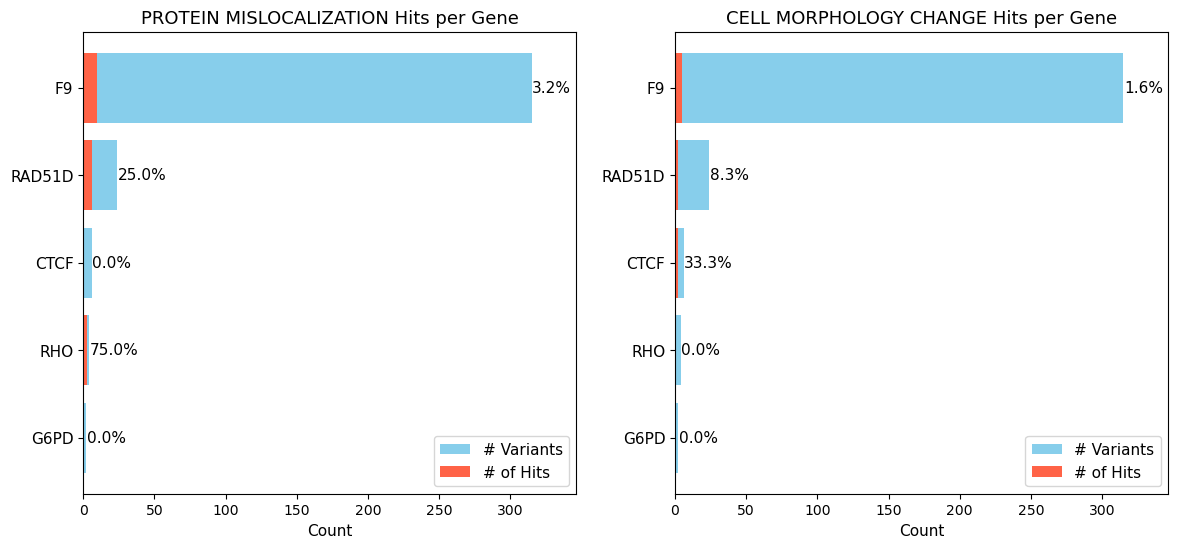

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_GFP_95_both_batches", "Protein Mislocalization", ax=ax[0])
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_Morph_95_both_batches", "Cell Morphology Change", ax=ax[1])
plt.subplots_adjust(wspace=0.2)

In [45]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True
        )

### 2.2 DUAL-IPA assay

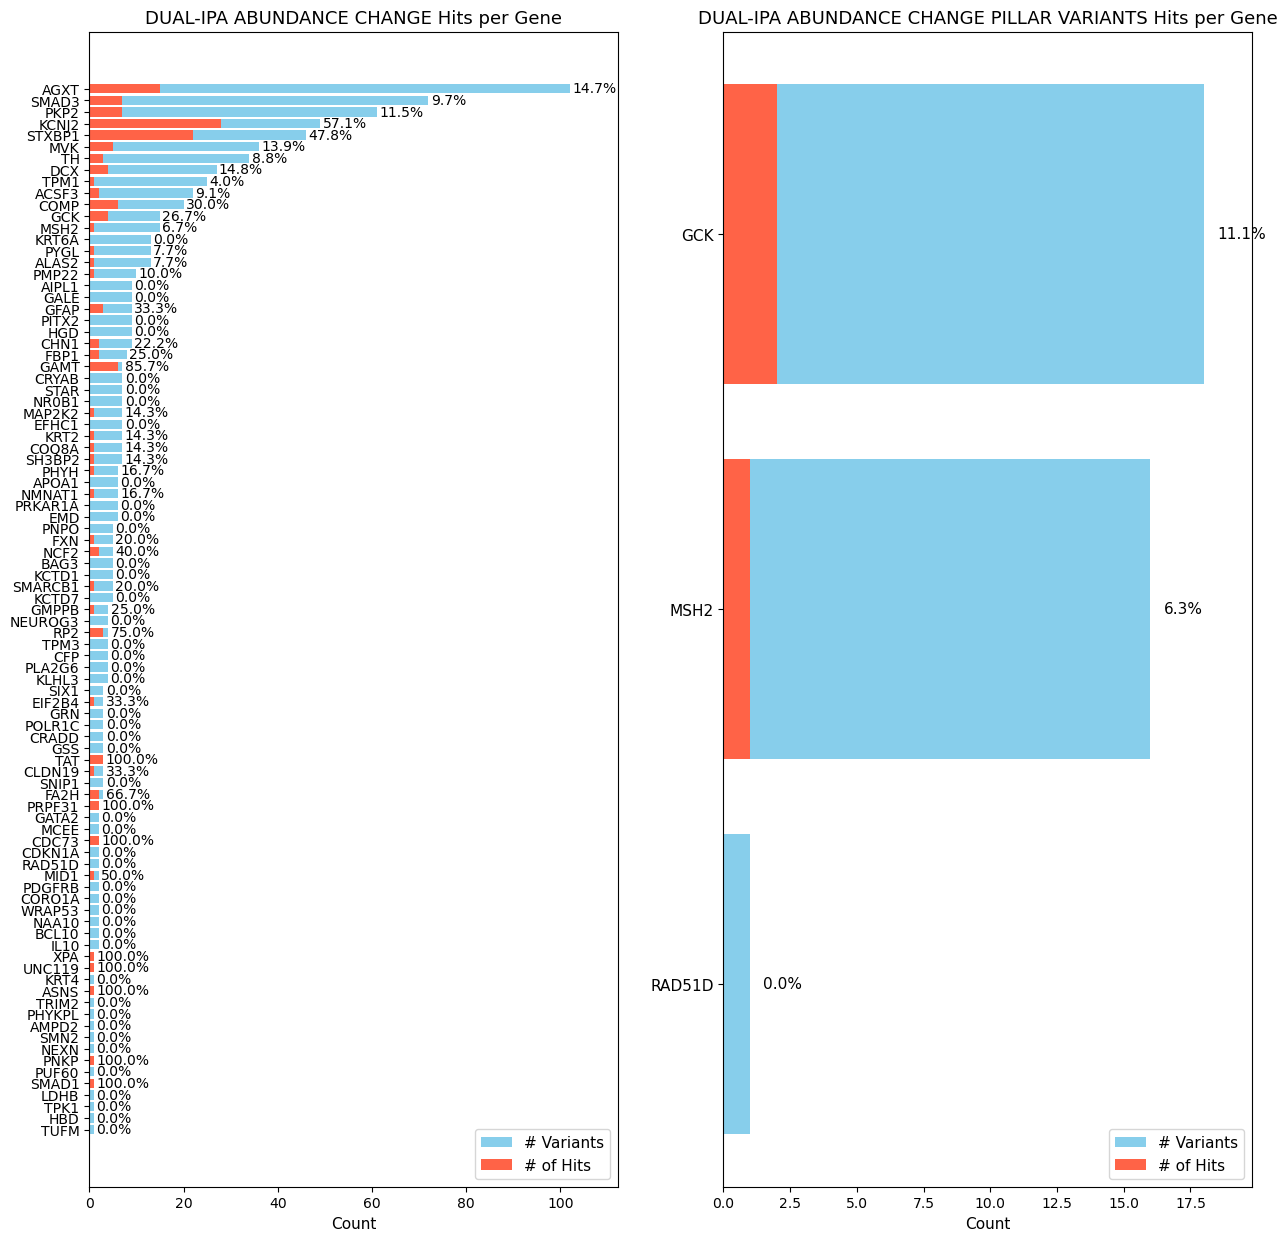

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
plot_gene_level_summary(dual_ipa_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change", ax=ax[0])
plot_gene_level_summary(pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change Pillar Variants", ax=ax[1])

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""MSH2_Lys627Asn""",null,"""Loss of function""","""Abnormal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Low abundance ""","""Abnormal"""
"""MSH2_Gly40Ser""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""GCK_Ala456Val""","""Pathogenic""","""Decreased activity""","""Abnormal"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""MSH2_Ala714Val""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""MSH2_Leu92Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""WT-like""","""Normal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Pro622Leu""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Thr335Ile""","""Uncertain significance""","""WT-like""","""Normal"""
"""MSH2_Glu562Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Ala305Thr""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""GCK_Ala456Val""","""Pathogenic""","""Hyperactive""","""Not specified"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""WT-like""","""Normal"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala456Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Met251Thr""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala378Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Synonymous""","""Abnormal"""
"""GCK_Met381Arg""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


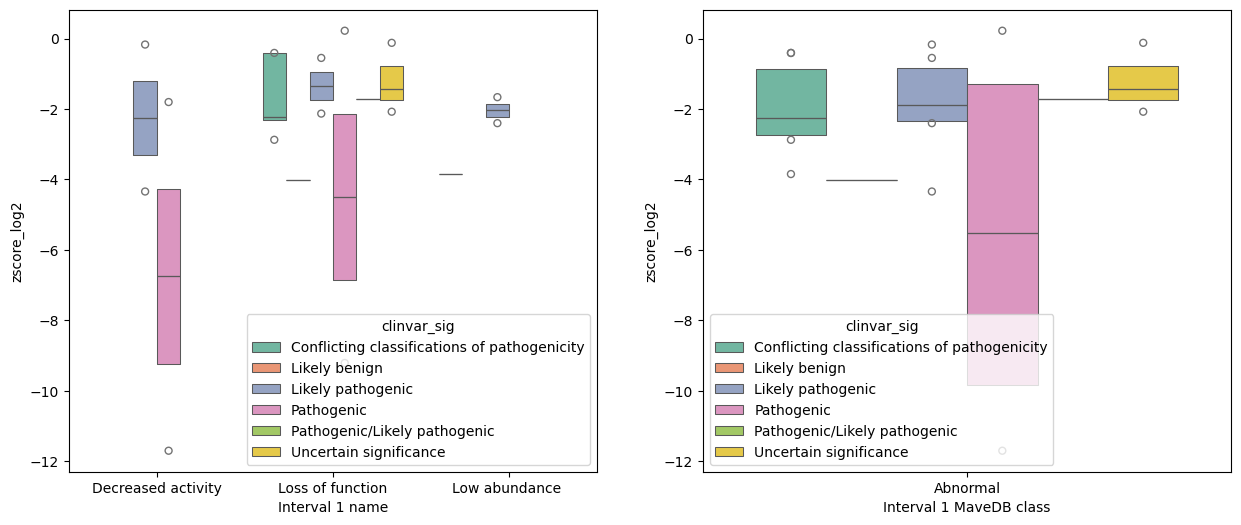

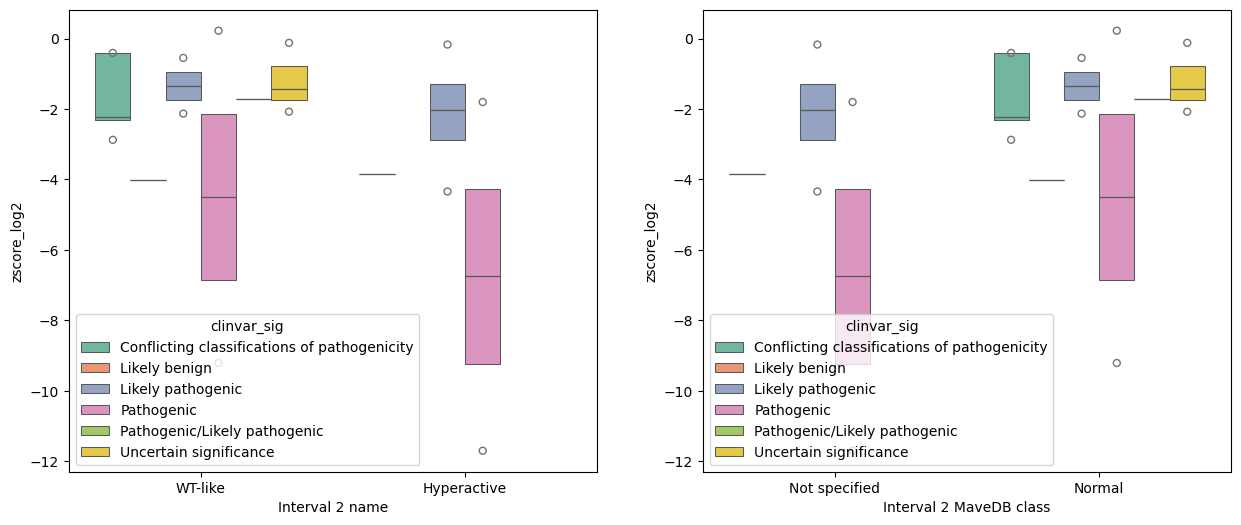

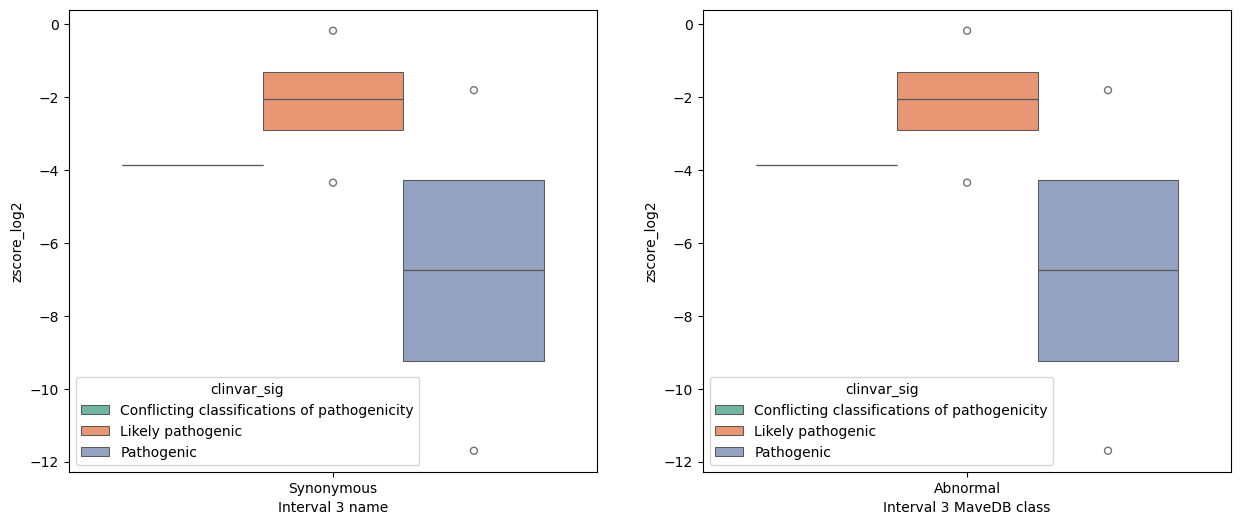

In [51]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_scores.drop_nulls("clinvar_sig").unique("clinvar_sig")["clinvar_sig"])
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )

### 2.3 PPI assays

In [56]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_PPI",int_name, mavedb_name])
    # print(func_scores)
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores["gene_variant","clinvar_sig",int_name, mavedb_name])
    # if func_scores.shape[0] > 0:
    #     fig, ax = plt.subplots(1,2,figsize=(12,6))
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=int_name,
    #         y="perturbed_percentage",
    #         ax=ax[0]
    #     )
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=mavedb_name,
    #         y="perturbed_percentage",
    #         ax=ax[1]
    #     )

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


In [57]:
ppi_df.filter(pl.col("gene_variant")=="GCK_Ala387Glu")

ad_orf_id,nt_change,final_score_wt,symbol,db_orf_id,edgotype,aa_change,final_score,ad_symbol,edgotype_wt_2,gene_variant,edgotype_wt_final,VarChAMP_PPI,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage
i64,str,i64,str,i64,str,str,i64,str,str,str,str,bool,i64,i64,i64,i64,f64,f64,f64
54784,"""1160C>A""",3,"""GCK""",3689,"""not perturbed""","""Ala387Glu""",3,"""GCKR""","""not perturbed""","""GCK_Ala387Glu""","""not perturbed""",true,2,1,0,1,50.0,0.0,50.0
70835,"""1160C>A""",4,"""GCK""",3689,"""perturbed""","""Ala387Glu""",0,"""SPDYE4""","""perturbed""","""GCK_Ala387Glu""","""perturbed""",true,2,1,0,1,50.0,0.0,50.0
